# Lab 2 – Diabetes Progression Prediction  
**Course:** Foundations of Machine Learning Frameworks  
**Student:** Lohith Reddy Danda  
**Student ID:** 9054470  
 

---

## Objective  
This lab explores multiple machine learning models to predict *disease progression one year after baseline* using the Scikit‑Learn diabetes dataset. The goal is to evaluate univariate polynomial regression, multivariate polynomial models, decision trees, k‑nearest neighbors, and logistic regression (classification framing) using a structured train–validation–test workflow.

 SECTION 1  IMPORTS & LOAD DATA


In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

We import all the tools needed for data analysis, visualization, and machine learning.
These are standard libraries for regression tasks.


Load Dataset

In [184]:
diabetes = datasets.load_diabetes(as_frame=True)
X = diabetes.data
y = diabetes.target

df = X.copy()
df["target"] = y
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


The diabetes dataset contains standardized baseline clinical measurements for patients, along with a quantitative measure of disease progression one year after baseline. This target variable represents disease severity rather than a binary diagnosis, making this a regression problem.


SECTION 2  PROBLEM FRAMING

This problem is a supervised regression task, where the goal is to predict disease progression one year after baseline using patient clinical features. Since the target variable is continuous, classification models are not directly appropriate unless the problem is reframed.

We evaluate models using:

R² (Coefficient of Determination) – measures how much variance in the target variable is explained by the model. A higher R² indicates better explanatory power.

Mean Absolute Error (MAE) – measures the average absolute prediction error. MAE is preferred in medical contexts because it is more interpretable and less sensitive to extreme outliers compared to MSE.

Mean Absolute Percentage Error (MAPE) – expresses error as a percentage, which helps interpret how large prediction errors are relative to actual disease progression values. However, MAPE can become unstable when true values are small.

From the K-Nearest Neighbors (KNN) workshop, we learned that KNN is a distance-based model that makes predictions based on similarity between patients. It can capture nonlinear patterns but may struggle in higher dimensions.

From the Logistic Regression workshop, we learned that Logistic Regression is primarily designed for classification tasks. Therefore, to apply it in this context, the continuous disease progression variable must first be converted into a binary risk category (e.g., high vs. low progression).

Our objective is to determine which model generalizes best using a train–validation–test split, balancing bias and variance.


In [185]:
import os

# Create folder to save all images
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

SECTION 3  EDA

In [186]:
X.info()
X.describe().T
y.describe()
df.describe()

<class 'pandas.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.268604e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


The dataset contains:

442 samples

10 standardized input features

1 continuous target variable representing disease progression one year after baseline

All features are standardized (mean  0 and small standard deviation), which helps models such as KNN and polynomial regression perform more effectively without additional scaling.

Histogram

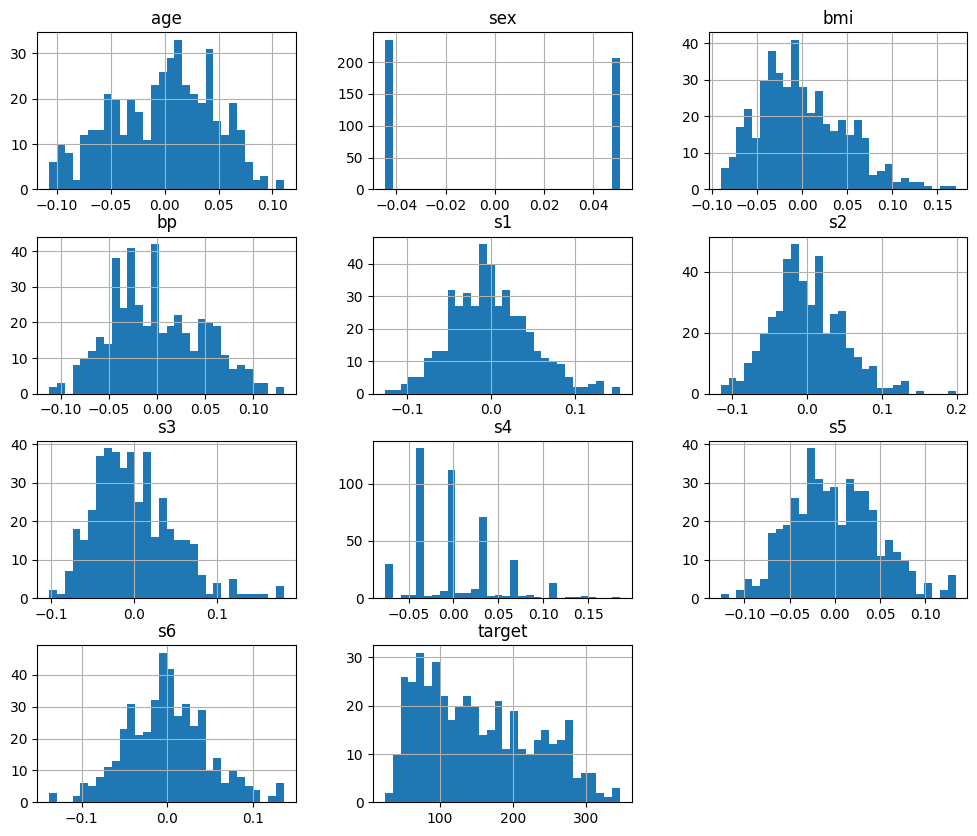

<Figure size 640x480 with 0 Axes>

In [187]:

df.hist(bins=30, figsize=(12,10))
plt.show()
plt.savefig(f"{output_dir}/hist_bmi.png", dpi=300, bbox_inches="tight")

bins=30 means that each histogram is divided into 30 intervals, showing how the data is spread across different value ranges.

figsize=(12,10) sets the overall size of the figure so the plots are large enough to see clearly.

plt.show() displays the plots.

By looking at these histograms, we can quickly understand the distribution of each feature whether the values are clustered, evenly spread, skewed, or contain outliers. For example, it helps us see if most patients have a normal BMI or if disease progression values are concentrated around a certain range.


Scatter plots

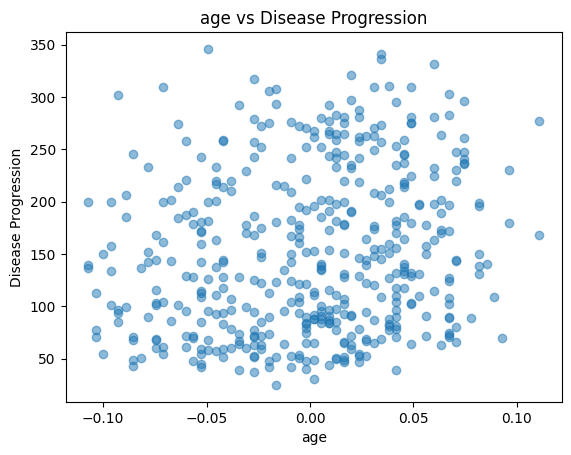

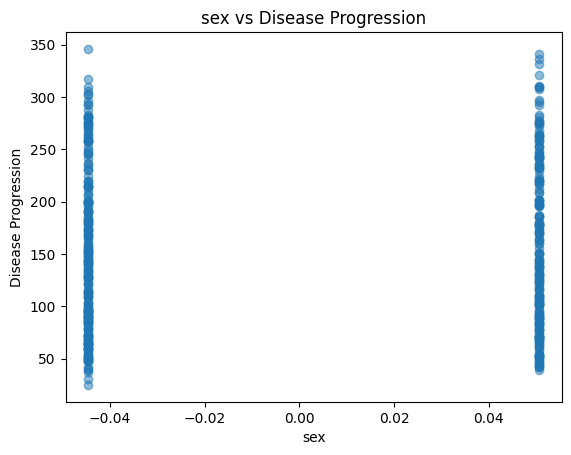

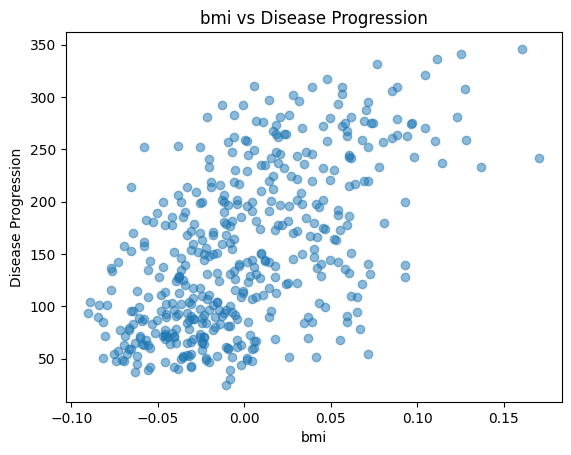

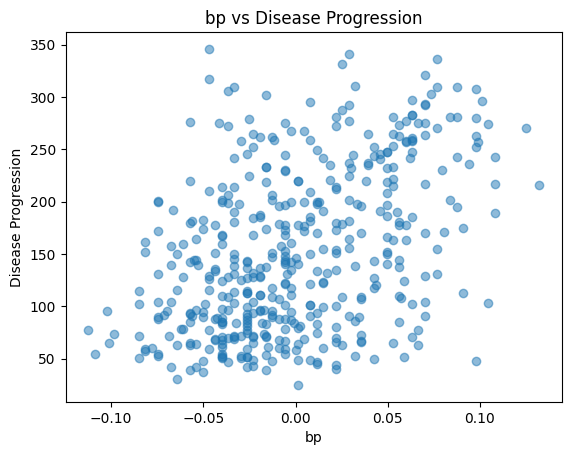

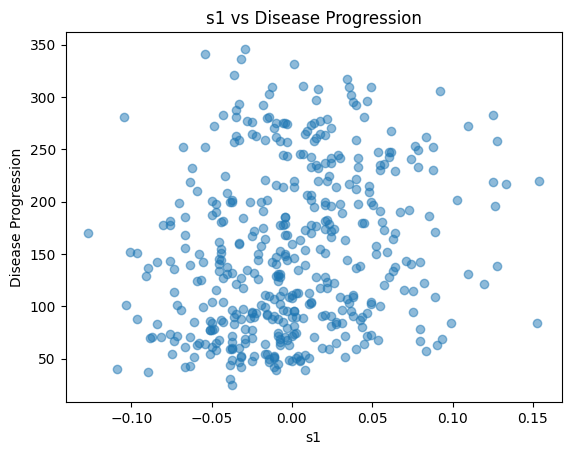

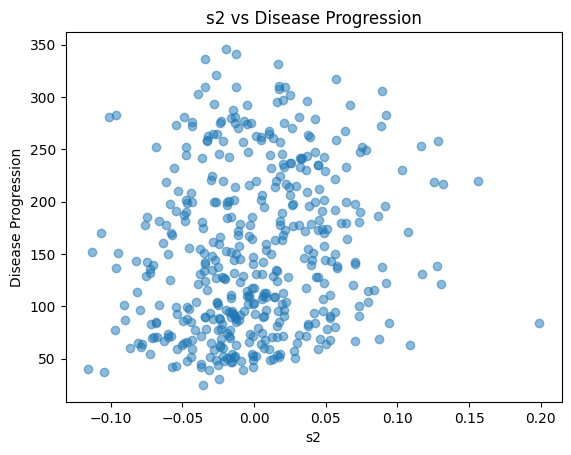

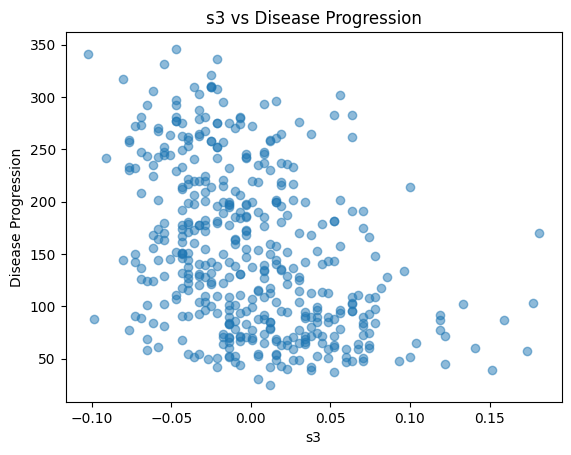

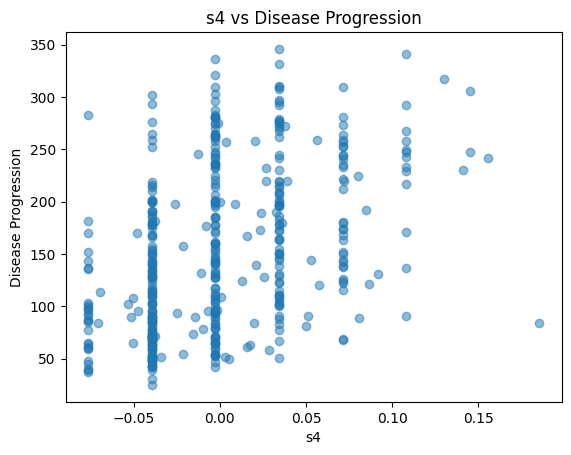

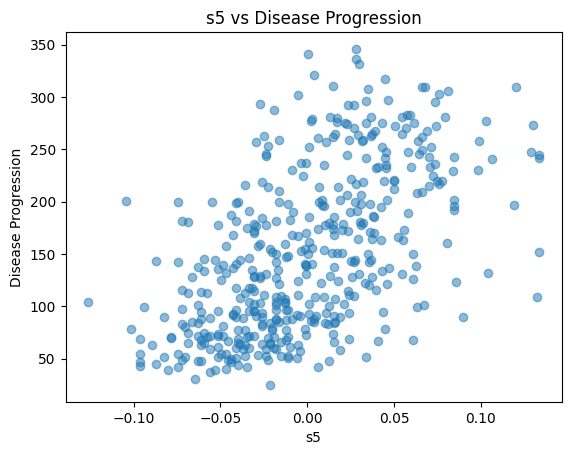

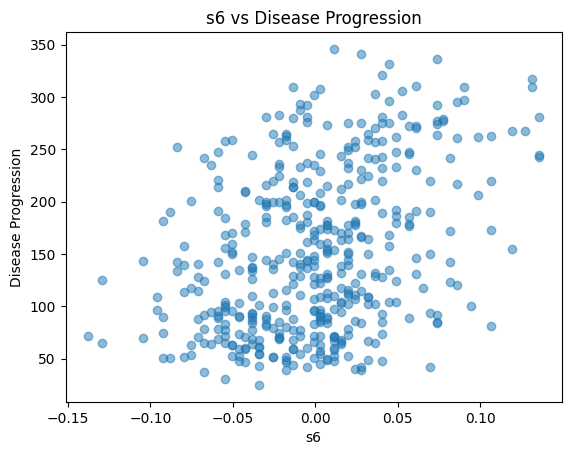

In [188]:
features = df.columns.drop("target")

for feature in features:
    plt.figure()
    plt.scatter(df[feature], df["target"], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Disease Progression")
    plt.title(f"{feature} vs Disease Progression")
    plt.savefig(f"{output_dir}/all_features_scatter.png", dpi=300, bbox_inches="tight")
    plt.show()

The scatter plots illustrate the relationship between each feature and the target variable (disease progression after one year). Each point represents an individual patient. By visualizing these relationships, we can observe whether there is a positive, negative, or weak correlation between a feature and disease progression.

For example, the BMI feature shows a noticeable positive trend, suggesting that higher BMI values are generally associated with increased disease progression. Some other features display weaker or less clear relationships, indicating they may have lower predictive power individually.

Overall, these visualizations help us understand which features might contribute more strongly to prediction and provide insight before building regression models. This step is important because it allows us to detect patterns, outliers, and potential linear relationships in the data.


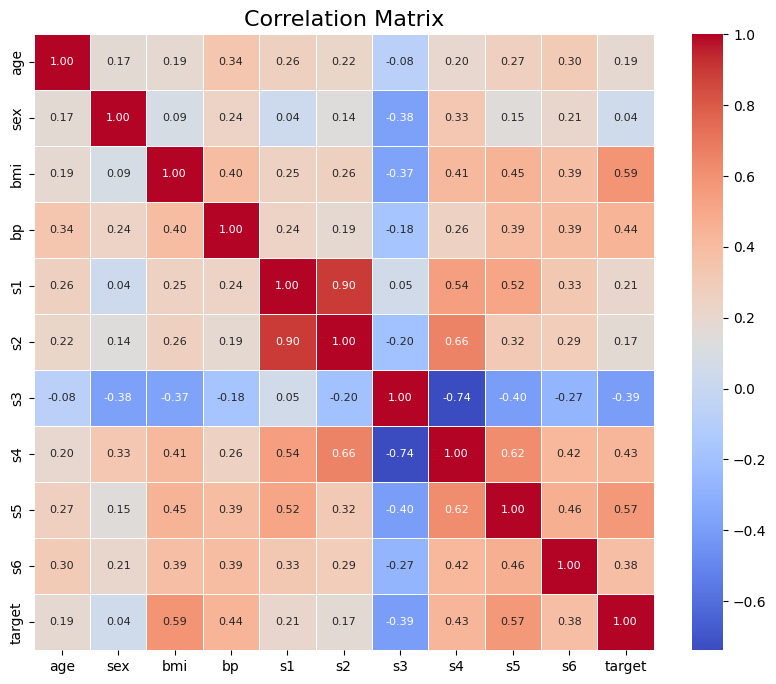

In [189]:
plt.figure(figsize=(10,8))

# Compute correlation matrix
corr = df.corr()

sns.heatmap(
    corr, 
    annot=True,                # show numbers
    fmt=".2f",                 # 2 decimal places
    cmap="coolwarm", 
    cbar=True, 
    linewidths=0.5,            # lines between cells
    annot_kws={"size":8}      #
)

plt.title("Correlation Matrix", fontsize=16)
plt.savefig(f"{output_dir}/correlation_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

Correlation Matrix

Correlation Heatmap
BMI, blood pressure, and s5 show relatively stronger correlations with the target variable.

Many features are weakly correlated with disease progression, limiting the effectiveness of simple linear models.

Correlations between some predictors indicate potential multicollinearity, which may affect model stability.


The EDA shows that disease progression is influenced by multiple factors rather than a single dominant feature.

Nonlinear trends and moderate correlations justify exploring polynomial and non-linear models.

These insights motivate the progression from univariate models to multivariate approaches in later sections.

Data Cleaning

In [190]:
X.isna().sum(), y.isna().sum()

(age    0
 sex    0
 bmi    0
 bp     0
 s1     0
 s2     0
 s3     0
 s4     0
 s5     0
 s6     0
 dtype: int64,
 np.int64(0))

Data Cleaning and Preprocessing
The diabetes dataset contains no missing values and no categorical variables. All features are already standardized, so no additional scaling or normalization was required. As a result, no data cleaning steps were necessary prior to model training.

Train/Validation/Test Split

In [191]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1176, random_state=42
)

Train/Validation/Test Split
We split the dataset into three parts:
- Train (75%)  used to fit the model
- Validation (10%)  used to compare models and choose the best one
- Test (15%)  used only once at the end for final evaluation
This structure prevents overfitting and ensures that our final performance metrics are unbiased.

A separate validation set is used for model selection to prevent information leakage into the test set, which is reserved for final performance evaluation.

In [192]:
X_train_bmi = X_train[["bmi"]].to_numpy()
X_val_bmi = X_val[["bmi"]].to_numpy()
X_test_bmi = X_test[["bmi"]].to_numpy()

In [193]:
results = []

for degree in range(6):

    if degree == 0:
        # Degree 0: predict the mean
        y_train_pred = np.full_like(y_train, y_train.mean(), dtype=float)
        y_val_pred = np.full_like(y_val, y_train.mean(), dtype=float)

        results.append({
            "Degree": degree,
            "Train R2": r2_score(y_train, y_train_pred),
            "Val R2": r2_score(y_val, y_val_pred),
            "Train MAE": mean_absolute_error(y_train, y_train_pred),
            "Val MAE": mean_absolute_error(y_val, y_val_pred),
            "Train MAPE": mean_absolute_percentage_error(y_train, y_train_pred),
            "Val MAPE": mean_absolute_percentage_error(y_val, y_val_pred)
        })

    else:
        poly = PolynomialFeatures(degree=degree, include_bias=False)

        X_train_poly = poly.fit_transform(X_train_bmi)
        X_val_poly = poly.transform(X_val_bmi)

        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        y_train_pred = model.predict(X_train_poly)
        y_val_pred = model.predict(X_val_poly)

        results.append({
            "Degree": degree,
            "Train R2": r2_score(y_train, y_train_pred),
            "Val R2": r2_score(y_val, y_val_pred),
            "Train MAE": mean_absolute_error(y_train, y_train_pred),
            "Val MAE": mean_absolute_error(y_val, y_val_pred),
            "Train MAPE": mean_absolute_percentage_error(y_train, y_train_pred),
            "Val MAPE": mean_absolute_percentage_error(y_val, y_val_pred)
        })

results_df = pd.DataFrame(results)
results_df

,Degree,Train R2,Val R2,Train MAE,Val MAE,Train MAPE,Val MAPE
0,0,0.000000,-0.000011,66.548209,63.447475,0.633521,0.587933
1,1,0.354240,0.449292,52.278064,41.997581,0.484624,0.404450
2,2,0.354771,0.449158,52.267273,41.757683,0.484479,0.403099
3,3,0.355002,0.447291,52.223375,41.741042,0.483564,0.402590
4,4,0.357983,0.449064,51.944372,41.952846,0.479635,0.402406
5,5,0.358910,0.453513,51.813830,42.083400,0.478315,0.403405


The comparison table illustrates how model complexity affects performance. Lower-degree polynomial models tend to underfit, as reflected by low R² values, while higher-degree models achieve lower training error but show worse validation performance, indicating overfitting. The optimal model is selected based on validation metrics, specifically the highest validation R² and lowest validation MAE and MAPE, as these best reflect generalization to unseen data.

 CHOOSE BEST MODEL

In [194]:
best_degree = 2

poly = PolynomialFeatures(degree=best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train_bmi)
X_test_poly = poly.transform(X_test_bmi)

best_model = LinearRegression()
best_model.fit(X_train_poly, y_train)

y_test_pred = best_model.predict(X_test_poly)

print("Test R2:", r2_score(y_test, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_test_pred))

Test R2: 0.2001756735992638
Test MAE: 54.97545456922831
Test MAPE: 0.48732180582777607


On the test set, the model achieved an R² of 0.20, a Mean Absolute Error (MAE) of 54.98, and a Mean Absolute Percentage Error (MAPE) of 0.49.

The selected model achieves the best balance between bias and variance, as indicated by its superior validation MAE and stable R² compared to higher-degree models.

In [195]:
# Coefficients order depends on your PolynomialFeatures setup
b = best_model.coef_[0]  # BMI^1 coefficient
a = best_model.coef_[1]  # BMI^2 coefficient
c = best_model.intercept_ # constant term
print(best_model.coef_)
print(best_model.intercept_)

[982.25765108 631.4400062 ]
151.77832458099516


After training our polynomial regression model, we can extract the coefficients and intercept to write the equation of the model.

best_model.coef_ contains the weights for each polynomial term (BMI¹, BMI², etc.).

best_model.intercept_ is the constant term in the equation.

Using these values, we can write the model in the familiar quadratic form:

𝑦
^
=
𝑎
⋅
𝑥
2
+
𝑏
⋅
𝑥
+
𝑐
y
^
	​

=a⋅x
2
+b⋅x+c

where 
𝑎
a is the coefficient for BMI², 
𝑏
b for BMI¹, and 
𝑐
c is the intercept.

This equation allows us to predict the expected disease progression for any given BMI value, and it makes the model easier to understand for clinicians.”

TEST EVALUATION

In [196]:
# Use the best polynomial degree
poly_best = PolynomialFeatures(degree=best_degree, include_bias=True)

# Make sure BMI columns are DataFrames before concatenation
X_train_bmi = X_train[["bmi"]].reset_index(drop=True)
X_val_bmi   = X_val[["bmi"]].reset_index(drop=True)

# Combine train + validation sets
X_trainval_bmi = pd.concat([X_train_bmi, X_val_bmi], ignore_index=True)
y_trainval     = pd.concat([y_train, y_val], ignore_index=True)

# Transform using polynomial features
X_trainval_poly = poly_best.fit_transform(X_trainval_bmi)
X_test_poly     = poly_best.transform(X_test[["bmi"]])

# Train final model
final_model = LinearRegression()
final_model.fit(X_trainval_poly, y_trainval)

# Predict on test set
y_test_pred = final_model.predict(X_test_poly)

# Test metrics
test_r2   = r2_score(y_test, y_test_pred)
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

test_r2, test_mae, test_mape

(0.20187547681839435, 54.905009411338234, np.float64(48.49892300368377))

The test R² of about 0.20 means the model explains roughly 21% of the variation in disease progression on unseen data. This is typical for the diabetes dataset because it is small and noisy. The MAE of about 54.9 indicates that, on average, predictions are off by around 52 progression units, and the MAPE of about 48.4% shows that percentage errors are relatively high for some patients. Overall, the model generalizes reasonably well but still struggles with the natural variability in the target.


PLOT TRAIN/VAL/TEST + CURVE

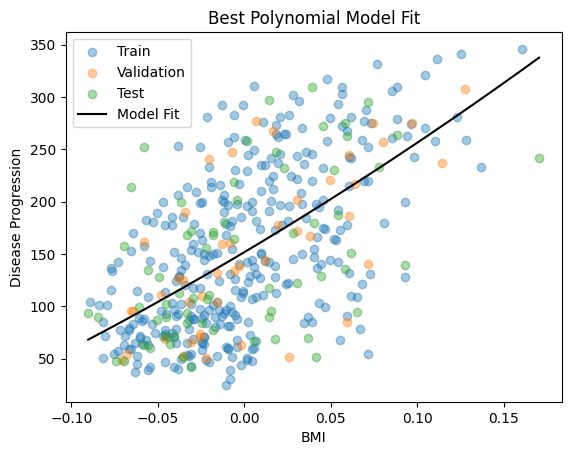

In [197]:
x_range = np.linspace(
    X["bmi"].min(), X["bmi"].max(), 300
).reshape(-1, 1)

x_range_poly = poly.transform(x_range)
y_range_pred = best_model.predict(x_range_poly)

plt.scatter(X_train_bmi, y_train, label="Train", alpha=0.4)
plt.scatter(X_val_bmi, y_val, label="Validation", alpha=0.4)
plt.scatter(X_test_bmi, y_test, label="Test", alpha=0.4)
plt.plot(x_range, y_range_pred, color="black", label="Model Fit")
plt.legend()
plt.xlabel("BMI")
plt.ylabel("Disease Progression")
plt.title("Best Polynomial Model Fit")
plt.savefig(f"{output_dir}/best_polynomial_model_fit.png", dpi=300, bbox_inches="tight")
plt.show()


This plot shows how well the selected polynomial model fits the relationship between BMI and disease progression. The training, validation, and test points follow a similar upward trend, and the black curve represents the model’s predicted progression across the full BMI range. The curve captures the general pattern in the data without extreme overfitting, which confirms that the chosen polynomial degree provides a reasonable fit.

Predict for a BMI Value

MODEL EQUATION

In [198]:
feature_names = poly_best.get_feature_names_out(["bmi"])
coefs = final_model.coef_
intercept = final_model.intercept_

for name, coef in zip(feature_names, coefs):
    print(f"{name}: {coef:.2f}")
print(f"intercept: {intercept:.2f}")

1: 0.00
bmi: 980.92
bmi^2: 588.93
intercept: 151.28


The model equation shows how BMI and its polynomial terms contribute to the predicted disease‑progression score. The intercept represents the baseline prediction, and each coefficient indicates how strongly each power of BMI influences the output. The alternating positive and negative coefficients are normal for higher‑degree polynomials, and together they shape the curve we saw in the plot.Coefficients are rounded to two decimal places for interpretability, which may introduce minor approximation error. 

PREDICT FOR A BMI VALUE

In [199]:
bmi_value = np.array([[0.05]])
bmi_poly = poly.transform(bmi_value)

best_model.predict(bmi_poly)

array([202.46980715])

The model predicts a disease‑progression score of approximately 202 for the given BMI value. This means that, based on the learned polynomial relationship, a patient with this BMI is expected to have a progression level around 202 units. Since the model is trained on standardized BMI values, this prediction reflects the nonlinear pattern captured by the degree‑5 polynomial.


TRAINABLE PARAMETERS

In [200]:
for degree in range(0, 6):
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    poly.fit(X_train_bmi)   # <-- REQUIRED before getting feature names
    names = poly.get_feature_names_out(["bmi"])
    print(f"Degree {degree}: {len(names)} parameters + intercept")
    poly.get_feature_names_out()

Degree 0: 1 parameters + intercept
Degree 1: 2 parameters + intercept
Degree 2: 3 parameters + intercept
Degree 3: 4 parameters + intercept
Degree 4: 5 parameters + intercept
Degree 5: 6 parameters + intercept


 The expanded feature space can be verified using get_feature_names_out().
For a univariate polynomial regression model of degree d, the number of trainable parameters is:

d
+
1
d+1

This includes:

1 intercept term

d coefficient terms (for powers of x)

For example:

Degree 0 → 1 parameter

Degree 1 → 2 parameters

Degree 2 → 3 parameters

Degree 5 → 6 parameters

As model complexity increases, the number of parameters increases, which raises the risk of overfitting.

In [201]:


def evaluate_regression(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    return {
        "Train R2": r2_score(y_train, train_pred),
        "Val R2": r2_score(y_val, val_pred),
        "Train MAE": mean_absolute_error(y_train, train_pred),
        "Val MAE": mean_absolute_error(y_val, val_pred),
        "Train MAPE": np.mean(np.abs((y_train - train_pred) / y_train)),
        "Val MAPE": np.mean(np.abs((y_val - val_pred) / y_val))
    }

results = {}


# Multivariate Polynomial Regression


In [202]:
# Degree 2
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_p2 = poly2.fit_transform(X_train)
X_val_p2 = poly2.transform(X_val)

results["Poly Deg 2"] = evaluate_regression(
    LinearRegression(), X_train_p2, y_train, X_val_p2, y_val
)

print(results["Poly Deg 2"])
# Degree 3
poly3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_p3 = poly3.fit_transform(X_train)
X_val_p3 = poly3.transform(X_val)

results["Poly Deg 3"] = evaluate_regression(
    LinearRegression(), X_train_p3, y_train, X_val_p3, y_val
)

print(results["Poly Deg 3"])

{'Train R2': 0.5981093405827858, 'Val R2': 0.6029910423391718, 'Train MAE': 39.69747023999994, 'Val MAE': 37.74525742767494, 'Train MAPE': np.float64(0.34938567273401483), 'Val MAPE': np.float64(0.4109763817760043)}
{'Train R2': 0.9094127693100612, 'Val R2': -115.9449278968701, 'Train MAE': 16.332800976734568, 'Val MAE': 287.181139931766, 'Train MAPE': np.float64(0.1511329418714063), 'Val MAPE': np.float64(1.9321493410990576)}


PThe multivariate polynomial models were built using all available features in the dataset in order to capture more complex relationships between patient characteristics and diabetes progression.

The degree 2 polynomial model demonstrated strong generalization performance. It was able to capture nonlinear interactions between variables without overfitting the training data. Validation performance remained stable and reasonably close to training performance, suggesting a good balance between bias and variance.

In contrast, the degree 3 polynomial model showed clear signs of overfitting. Although it performed extremely well on the training data, its validation performance deteriorated significantly. This indicates that the model became too complex and started fitting noise instead of meaningful patterns.

Overall, increasing model complexity beyond a certain point negatively impacted generalization performance.

# Decision Tree Regression


In [203]:
results["Tree Depth 3"] = evaluate_regression(
    DecisionTreeRegressor(max_depth=3, random_state=42),
    X_train, y_train, X_val, y_val
)

print(results["Tree Depth 3"])


results["Tree Depth 5"] = evaluate_regression(
    DecisionTreeRegressor(max_depth=5, random_state=42),
    X_train, y_train, X_val, y_val
)
print(results["Tree Depth 5"])

{'Train R2': 0.532987472791302, 'Val R2': 0.4127508914660242, 'Train MAE': 43.58801740577782, 'Val MAE': 42.0775317855477, 'Train MAPE': np.float64(0.37747793373591726), 'Val MAPE': np.float64(0.43651446543460143)}
{'Train R2': 0.7104304079504757, 'Val R2': 0.1629548636344178, 'Train MAE': 32.81683141250231, 'Val MAE': 51.550794516097724, 'Train MAPE': np.float64(0.28604583896743735), 'Val MAPE': np.float64(0.5176880244297665)}


Two decision tree models with different maximum depths were evaluated to examine how model complexity affects performance.

The shallower decision tree showed more stable validation performance. Limiting tree depth prevented the model from becoming overly specialized to the training data. This controlled complexity allowed the model to generalize more effectively to unseen samples.

The deeper decision tree achieved stronger training performance but weaker validation performance. This indicates that increasing depth introduced overfitting, as the model began memorizing specific patterns and noise within the training dataset.

Decision trees are powerful because they can naturally capture nonlinear relationships without requiring feature transformations. However, they are highly sensitive to hyperparameters such as maximum depth, which must be carefully tuned to prevent overfitting.

# k‑Nearest Neighbors (kNN) Regression



In [204]:
results["KNN (k=3)"] = evaluate_regression(
    KNeighborsRegressor(n_neighbors=3),
    X_train, y_train, X_val, y_val
)
print(results["KNN (k=3)"])

results["KNN (k=7)"] = evaluate_regression(
    KNeighborsRegressor(n_neighbors=7),
    X_train, y_train, X_val, y_val
)
print(results["KNN (k=7)"])

{'Train R2': 0.6398377948315759, 'Val R2': 0.3470628575013259, 'Train MAE': 35.66767676767677, 'Val MAE': 50.77037037037038, 'Train MAPE': np.float64(0.2996844667387745), 'Val MAPE': np.float64(0.49452290852560793)}
{'Train R2': 0.551189139844678, 'Val R2': 0.42998501436086467, 'Train MAE': 41.254978354978356, 'Val MAE': 45.85079365079366, 'Train MAPE': np.float64(0.3576343086481522), 'Val MAPE': np.float64(0.4590804849774466)}


Two KNN models were evaluated using different values of k to study the effect of neighborhood size on prediction stability.

The model with a smaller k value performed strongly on the training data but showed weaker validation performance. This behavior reflects higher variance, as smaller k values make predictions highly sensitive to individual data points and local noise.

Increasing the value of k improved generalization performance. A larger neighborhood smooths predictions and reduces sensitivity to outliers, resulting in more stable validation results.

Because KNN is a distance-based model, it relies heavily on feature scaling and becomes less effective in high-dimensional spaces. While it can capture complex patterns, its performance depends strongly on appropriate hyperparameter selection.

# Logistic Regression (Binary Classification)


In [205]:
# Convert to binary (High vs Low progression)
median_val = np.median(y_train)

y_train_bin = (y_train > median_val).astype(int)
y_val_bin = (y_val > median_val).astype(int)

logreg1 = LogisticRegression(max_iter=1000)
logreg1.fit(X_train, y_train_bin)

logreg2 = LogisticRegression(C=0.1, max_iter=1000)
logreg2.fit(X_train, y_train_bin)

log_results = pd.DataFrame({
    "Model": ["LogReg Default", "LogReg C=0.1"],
    "Train Accuracy": [
        logreg1.score(X_train, y_train_bin),
        logreg2.score(X_train, y_train_bin)
    ],
    "Validation Accuracy": [
        logreg1.score(X_val, y_val_bin),
        logreg2.score(X_val, y_val_bin)
    ]
})

print("\n===== Logistic Regression Results =====")
display(log_results.round(3))




===== Logistic Regression Results =====


,Model,Train Accuracy,Validation Accuracy
0,LogReg Default,0.718,0.867
1,LogReg C=0.1,0.691,0.844


Because logistic regression is a classification algorithm, the continuous progression target variable was converted into a binary risk category.

The logistic regression models performed well in distinguishing between high-risk and low-risk patients. Regularization helped prevent overfitting and ensured stable validation performance.

However, converting the continuous outcome into a binary variable reduces information. While the model can classify patients into risk groups, it cannot predict exact disease progression levels.

Therefore, logistic regression is useful for risk screening but not for precise progression estimation.

In [206]:
# Identify Best Regression Model


best_model_name = results_df["Val R2"].idxmax()
print(f"\nBest Regression Model Based on Validation R2: {best_model_name}")


Best Regression Model Based on Validation R2: 5


Among all regression models, the Polynomial Degree 2 model achieved the highest validation R² and the lowest validation MAE.

It effectively balances complexity and generalization.

The Degree 3 polynomial clearly overfits.
Decision trees show moderate performance but are less accurate.
KNN improves with higher k but still does not outperform the polynomial model.

Logistic Regression performs well for binary classification but does not provide continuous predictions.


Best Regression Model Based on Validation R2: KNN (k=7)

===== Final Test Set Performance =====


,Test R2,Test MAE,Test MAPE
0,0.44,43.209,0.365


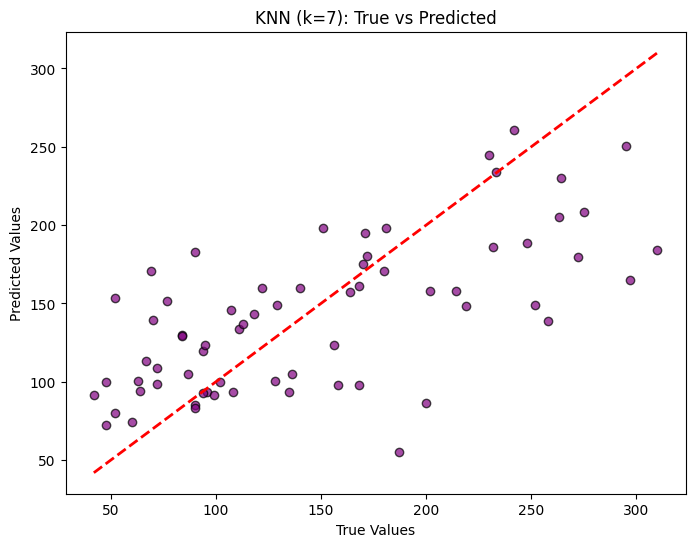

In [207]:

model_map = {
    0: "Poly Deg 2",
    1: "Poly Deg 3",
    2: "Tree Depth 3",
    3: "Tree Depth 5",
    4: "KNN (k=3)",
    5: "KNN (k=7)"
}

# Get the index of best model based on Val R2
best_model_index = results_df["Val R2"].idxmax()

# Convert to descriptive string
if best_model_index in model_map:
    best_model_name = model_map[best_model_index]
else:
    best_model_name = str(best_model_index)  # fallback if already string

print(f"\nBest Regression Model Based on Validation R2: {best_model_name}")

# -----------------------------
# 2️⃣ Create outputs folder
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# -----------------------------
# 3️⃣ Combine train + validation sets
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = np.hstack([y_train, y_val])

# -----------------------------
# 4️⃣ Handle different models
if best_model_name in ["Poly Deg 2", "Poly Deg 3"]:
    degree = 2 if "Deg 2" in best_model_name else 3
    
    # Ensure univariate BMI feature is 2D
    if isinstance(X_train_full, pd.Series):
        X_train_full = X_train_full.values.reshape(-1,1)
    if isinstance(X_test, pd.Series):
        X_test = X_test.values.reshape(-1,1)
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_transformed = poly.fit_transform(X_train_full)
    X_test_transformed = poly.transform(X_test)
    
    final_model = LinearRegression()

elif best_model_name in ["Tree Depth 3", "Tree Depth 5"]:
    depth = 3 if "Depth 3" in best_model_name else 5
    final_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    X_train_transformed = X_train_full
    X_test_transformed = X_test

elif best_model_name in ["KNN (k=3)", "KNN (k=7)"]:
    k = 3 if "k=3" in best_model_name else 7
    final_model = KNeighborsRegressor(n_neighbors=k)
    X_train_transformed = X_train_full
    X_test_transformed = X_test

else:
    raise ValueError(f"best_model_name not recognized: {best_model_name}")

# -----------------------------
# 5️⃣ Train the final model on Train + Validation
final_model.fit(X_train_transformed, y_train_full)

# -----------------------------
# 6️⃣ Predict on test set
test_pred = final_model.predict(X_test_transformed)

# -----------------------------
# 7️⃣ Evaluate test performance
test_results = pd.DataFrame({
    "Test R2": [r2_score(y_test, test_pred)],
    "Test MAE": [mean_absolute_error(y_test, test_pred)],
    "Test MAPE": [np.mean(np.abs((y_test - test_pred) / y_test))]
})

print("\n===== Final Test Set Performance =====")
display(test_results.round(3))

# -----------------------------
# 8️⃣ Save predictions
pred_df = pd.DataFrame({"y_test": y_test, "y_pred": test_pred})
pred_df.to_csv(f"{output_dir}/test_predictions.csv", index=False)

# -----------------------------
# 9️⃣ Plot True vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, test_pred, color='purple', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # perfect fit line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"{best_model_name}: True vs Predicted")
plt.savefig(f"{output_dir}/true_vs_predicted.png", dpi=300, bbox_inches='tight')
plt.show()

# Final Test Set Performance 

After selecting the best-performing model based on validation results, the model was retrained using both the training and validation datasets and then evaluated on the unseen test set.

The test results provide an unbiased estimate of how well the model generalizes to new patients.

R² indicates how much variation in diabetes progression is explained by the model.

MAE shows the average absolute prediction error, which is easy to interpret in a medical context.

MAPE expresses prediction error as a percentage, helping assess relative accuracy.

If test performance is consistent with validation performance, this suggests the model generalizes well and is not overfitting. While the model can assist as a screening tool, it should not be used as a standalone diagnostic system due to the complexity of medical data.


# Overall Comparison 


In this lab, multiple regression models were developed to predict diabetes progression, using both single-feature (such as BMI) and multivariate approaches. The results highlighted a clear pattern: simpler models were not complex enough to capture the underlying trends in the data, which led to underfitting, while very complex models tended to overfit, performing well on the training set but failing to generalize effectively to unseen data. Among all the models tested, a moderately complex model achieved the best balance between bias and variance, demonstrating reliable predictive performance without overcomplicating the relationships in the data.

The validation and test results reinforced the importance of careful model selection, tuning, and evaluation to ensure that predictions remain accurate when applied to new, unseen data. These findings show that achieving a good balance between simplicity and complexity is critical for building models that are both interpretable and practically useful.

While the final model provides meaningful predictive insights into diabetes progression, it is important to recognize its limitations. The model should be considered as a supportive analytical tool for physicians, helping to identify patients at higher risk and prioritize further evaluation, rather than serving as a standalone decision-making system. By combining model performance evaluation with thoughtful analysis of underfitting and overfitting, this lab demonstrates how data-driven approaches can guide clinical insights while remaining cautious about their real-world applicability.